# Activity Analysis Demonstration script
This notebook draws from the demo 1 file of ActivityAnalysisToolbox_2.1

This notebook demonstrates the use of the activity analysis python library, built on pandas, scipy, numpy, and math libraries. 

The purpose and origins of activity analysis is explained in:
Upham, F., McAdams, S. "Activity Analysis and Continuous Responses to Music" or whatever it was. Audiences? audiences were in the title, I'm sure.

Currently, the library is still in development, but it can be installed from the test repo:

    pip install -i https://test.pypi.org/simple/ aa-test-package

In [1]:
import sys
import os
import time
import datetime as dt
import math
import numpy as np 
import scipy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
from scipy.signal import butter,filtfilt
from scipy.interpolate import interp1d

import activityanalysis as act


Load Korhonen's emotion ratings data, currently in mat files.

TODO: export these data to csv to be shared and bundled with library

In [2]:
import scipy.io
mat = scipy.io.loadmat('data/Korhonen.mat')
c = mat['Kor']
Kor = []
for stim in range(len(c)):
    Data = pd.DataFrame()
    Time = []
    t = c[stim][0][0][0][0]
    d = c[stim][0][0][0][1]
    for i in range(len(c[11][0][0][0][0])):
        Time.append(t[i][0])
        Data = Data.append( pd.Series(d[i]), ignore_index=True)
    Data.index = Time
    sF = c[stim][0][0][0][2][0][0]
    Np = c[stim][0][0][0][3][0][0]
    Measure = c[stim][0][0][0][4][0]
    Piece = c[stim][0][0][0][5][0]
    Audience = c[stim][0][0][0][6][0]
    NrData = pd.DataFrame()
    d = c[stim][0][0][0][7]
    for i in range(len(c[11][0][0][0][0])):
        NrData = NrData.append( pd.Series(d[i]), ignore_index=True)
    NrData.index = Time
    NzData = pd.DataFrame()
    d = c[stim][0][0][0][8]
    for i in range(len(c[11][0][0][0][0])):
        NzData = NzData.append( pd.Series(d[i]), ignore_index=True)
    NzData.index = Time
    Spec = c[stim][0][0][0][9]
    coll = {'Time':Time,
       'Data': Data,
       'sF':sF,
       'Np':Np,
       'Measure':Measure,
       'Piece':Piece,
       'Audience':Audience,
       'NrData':NrData,
       'NzData': NzData,
       'Spec':Spec}
    Kor.append(coll)

Select a collection of ratings to evaluate, in this case, the valence dimension of the emotion ratings to Copeland's Fanfare for the Common Man.

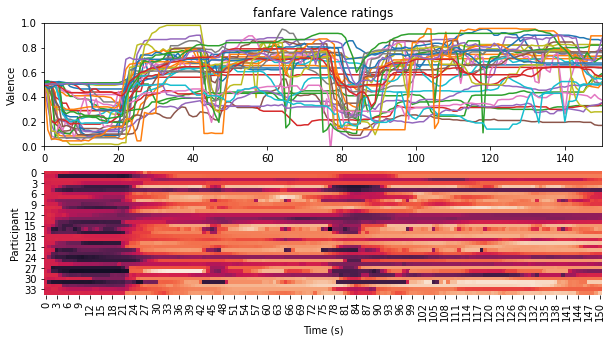

In [5]:
# select collection of ratings
collN = 5
D = Kor[collN]

fig = plt.figure(figsize=(10,5))
# plot the ratings in their original ratings
ax = fig.add_subplot(211)
D['Data'].plot(ax=ax,legend=False)
plt.ylim(0,1)
plt.xlim(D['Time'][0],D['Time'][-1])
plt.title(D['Piece'] + ' ' + D['Measure'] + ' ratings')
plt.ylabel(D['Measure'])
# plot the ratings as a heatmap, so they don't block each other. Note: order of participants is arbitrary.
ax = fig.add_subplot(212)
sns.heatmap(D['Data'].transpose(),ax=ax,cbar=False)#, cmap="YlGnBu")
plt.ylabel('Participant')
plt.xlabel('Time (s)')
plt.show()

The Valence dimension of emotion ratings to musical stimulus from 35 participants, sampled at 1 hz. The top plot shows the ratings in the original rating scale [0,1]. The lower plots each response as a row, with colour reporting valence values black=0 to white = 1.

The raw ratings show a lot of consistency, with many lines moving from the negative valence range (<0.5) to the positive (>0.5). This is visible in both plots, although concensus is not unanimous. Are these consistencies in how the ratings change driven by the shared stimulus? This can be evaluated statistically.

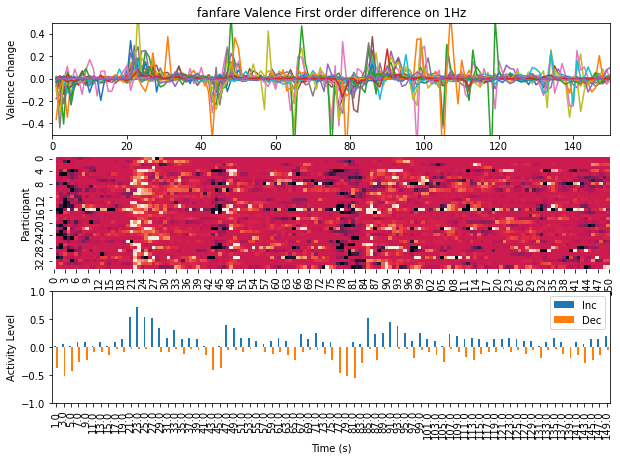

In [8]:
fig = plt.figure(figsize=(10,7))

# plot the changes in ratings as the first order difference series on these 1 Hz sampled continuous ratings.
#line plot
ax = fig.add_subplot(311)
D['Data'].diff().plot(ax=ax,legend=False)
plt.ylim(-0.5,0.5)
plt.xlim(D['Time'][0],D['Time'][-1])
plt.title(D['Piece'] + ' ' + D['Measure'] + ' First order difference on ' + str(D['sF']) + 'Hz')
plt.ylabel(D['Measure'] + ' change')
# heatmap
ax = fig.add_subplot(312)
sns.heatmap(D['Data'].diff().transpose(),ax=ax,cbar=False,vmin=-0.1, vmax=0.1)#, cmap="YlGnBu")
plt.ylabel('Participant')

# evaluate the changes in terms of "activity" for activity analysis.
FrameSize = 2 # evaluate whether a response shows an event over 2 second time frames
HopSize = 2 # evaluate frames every 2 seconds. With HopSize=FrameSize the activity assessed is non-overlapping, i.e. independent.
Thresh = 0.025 # the scalar minimum value of rating change needed in a frame to be counted as an event

# Count the number of responses showing activity in each frame
# ACTS is a pandas dataframe with:
#       - an index of time stamps corresponding to the frame midpoints
#       - point process columns for each response in D['Data'], 
#              with 1 indicating detected activity for that response in that frame, 
#              0 no activity detected
#       - a final column 'Total' reporting the ratio of responses showing activity in each time frame
# first we evaluate the activity levels for increases in ratings (greater than Thresh)
ACTS=act.activityCount(D['Data'],FrameSize,HopSize,Thresh,'Inc')
AC=pd.DataFrame({'Inc':ACTS['Total']})
# then we evaluate the activity levels for decreases in ratings (greater than Thresh)
ACTS=act.activityCount(D['Data'],FrameSize,HopSize,Thresh,'Dec')
AC['Dec'] = -ACTS['Total']

ax = fig.add_subplot(313)
# plot the activity levels for rating changes (inc/dec)
AC.plot.bar(ax=ax)
plt.ylim(-1,1)
plt.ylabel('Activity Level')
plt.xlabel('Time (s)')
plt.show()

Looking at the patterns of rating changes in this same collection of responses. 

Top plot is the first order difference in the original rating scale ploted as lines. There are concentrations of increases and decreses but with so many responses, it is hard to see how popular these behaviours may be at any given moment.

Second plot is the same values ploted in colours of each response rows, showing stripes of direction of change at specific moments such as the increases at 21-30 s and decreases of great popularity at the begining and 78-84s. Are these concentrations stimulus driven?

Third plot reports the activity-level time series for increases of at least 0.025 (above zero) and decreases of at least 0.025 in non-overlapping 2 s frames. Rarely are as much as half the participants changing ratings at the same time in the same direction, but there looks to be a strong pattern of creses and valleys. These patterns can be assessed against a null hypothesis of stimulus-independent rating changes with activty analysis tests of coordination.

Chi-square for goodness of fit over 5 bins: 37.03
        p value = 1.772398814794558e-07


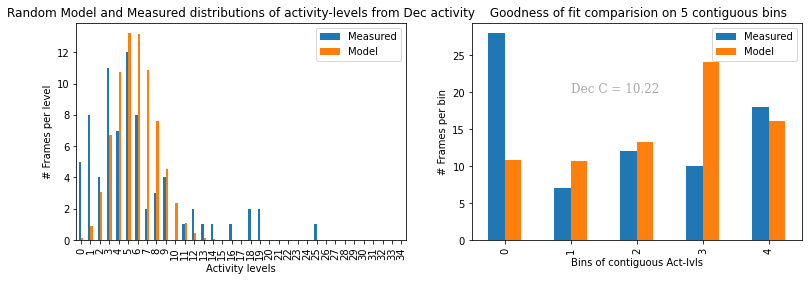

In [35]:
# evaluate 
S = D['Data'].shape
Np = S[1]
Nbins = 5

# simpleActivityTest(Activity-levels, Number of responses, number of bins for goodness of fit test)
# Evaluate the distribution of activity-levels as evaluated with activityCount for likelyhood to have
# arisen from rating changes independent of the stimulus.
# the stats output of simpleActivityTest is a dictionary with:
#       - 'Chi2': the goodness of fit statistics
#       - 'pvalue': the pvalue from the goodness of fit test, 
#       - 'Counts': a pandas dataframe with an index of activity levels (unit valued) 
#              'Model' column of number of frames expected of each activity level, were the event to be independent of the stimulus 
#              'Measured' column of number of frames observed to reach each activity level
#       - 'Bis': a pandas dataframe with an index of bins representing a contiguous range of activity levels
#              'Model' column of number of frames expected per bin, with a minimum of 5. If less, the function reevaluates on Nbins-1. Bin ranges cut to be maximally even
#              'Measured' column of number of frames observed to reach each bin

# first we evaluate the activity levels for increases in ratings (greater than Thresh)
ACTS=act.activityCount(D['Data'],FrameSize,HopSize,Thresh,'Inc')
# generate the stats
stats = act.simpleActivityTest(ACTS['Total'],Np,Nbins)

print('Chi-square for goodness of fit over ' + str(Nbins) +' bins: ' + str(np.round(stats['Chi2'],2)))
print('        p value = ' + str(stats['pvalue']))

fig = plt.figure(figsize=(13,4))
ax = fig.add_subplot(121)
stats['Counts'].plot.bar(ax=ax)
plt.title('Random Model and Measured distributions of activity-levels from ' + actType + ' activity' )
plt.ylabel('# Frames per level')
plt.xlabel('Activity levels')
ax = fig.add_subplot(122)
stats['Bins'].plot.bar(ax=ax)
plt.title(' Goodness of fit test on ' + str(Nbins) + ' contiguous bins')
plt.ylabel('# Frames per bin')
plt.xlabel('Bins of contiguous Act-lvls')

# coordScoreSimple(Response dataframe,FrameSize,Thresh,actType,Nbins)
# this function evaluates the goodness of fit of stimulus-independent response activity and generates a coordination score.
# the coordination score is the average negative log of the pvalue for frames with different offsets.
# This parametric test requires frames to be non-overlapping, but the frame boundaries maybe them split
# appart response activity prompted by the same stimulus event or moment. To compensate, the test is reapplied
# to the range of possible starting points within the duration of a frame, and the scores averaged, when the Frame is larger than a single sample.
# the output of coordScoreSimple is a dictionary with:
#       - 'CS': a score between 0 and 16, with 2 matching (an average) pvalue of 0.01.

CInc = act.coordScoreSimple(D['Data'],FrameSize,Thresh,actType,Nbins)
font = {'family': 'serif',
        'color':  'darkgrey',
        'weight': 'normal',
        'size': 12,
        }
plt.text(1, 20, actType + ' C = ' + str(np.round(CInc,2)), fontdict=font)

plt.show()

Chi-square for goodness of fit over 5 bins: 37.03
        p value = 1.772398814794558e-07


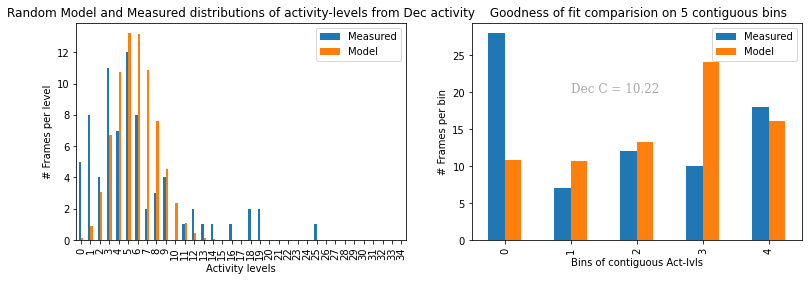

In [35]:
# TODO adapt to alternating activity 
# evaluate 
S = D['Data'].shape
Np = S[1]
Nbins = 5

# alternatingActivityTest(Activity-levels, Number of responses, number of bins for goodness of fit test)
# Evaluate the distribution of activity-levels as evaluated with activityCount for likelyhood to have
# arisen from rating changes independent of the stimulus.
# the stats output of simpleActivityTest is a dictionary with:
#       - 'Chi2': the goodness of fit statistics
#       - 'pvalue': the pvalue from the goodness of fit test, 
#       - 'Counts': a pandas dataframe with an index of activity levels (unit valued) 
#              'Model' column of number of frames expected of each activity level, were the event to be independent of the stimulus 
#              'Measured' column of number of frames observed to reach each activity level
#       - 'Bis': a pandas dataframe with an index of bins representing a contiguous range of activity levels
#              'Model' column of number of frames expected per bin, with a minimum of 5. If less, the function reevaluates on Nbins-1. Bin ranges cut to be maximally even
#              'Measured' column of number of frames observed to reach each bin

# first we evaluate the activity levels for increases in ratings (greater than Thresh)
ACTS=act.activityCount(D['Data'],FrameSize,HopSize,Thresh,'Inc')
# generate the stats
stats = act.simpleActivityTest(ACTS['Total'],Np,Nbins)

print('Chi-square for goodness of fit over ' + str(Nbins) +' bins: ' + str(np.round(stats['Chi2'],2)))
print('        p value = ' + str(stats['pvalue']))

fig = plt.figure(figsize=(13,4))
ax = fig.add_subplot(121)
stats['Counts'].plot.bar(ax=ax)
plt.title('Random Model and Measured distributions of activity-levels from ' + actType + ' activity' )
plt.ylabel('# Frames per level')
plt.xlabel('Activity levels')
ax = fig.add_subplot(122)
stats['Bins'].plot.bar(ax=ax)
plt.title(' Goodness of fit test on ' + str(Nbins) + ' contiguous bins')
plt.ylabel('# Frames per bin')
plt.xlabel('Bins of contiguous Act-lvls')

# coordScoreSimple(Response dataframe,FrameSize,Thresh,actType,Nbins)
# this function evaluates the goodness of fit of stimulus-independent response activity and generates a coordination score.
# the coordination score is the average negative log of the pvalue for frames with different offsets.
# This parametric test requires frames to be non-overlapping, but the frame boundaries maybe them split
# appart response activity prompted by the same stimulus event or moment. To compensate, the test is reapplied
# to the range of possible starting points within the duration of a frame, and the scores averaged, when the Frame is larger than a single sample.
# the output of coordScoreSimple is a dictionary with:
#       - 'CS': a score between 0 and 16, with 2 matching (an average) pvalue of 0.01.

CInc = act.coordScoreSimple(D['Data'],FrameSize,Thresh,actType,Nbins)
font = {'family': 'serif',
        'color':  'darkgrey',
        'weight': 'normal',
        'size': 12,
        }
plt.text(1, 20, actType + ' C = ' + str(np.round(CInc,2)), fontdict=font)

plt.show()

The measured activity levels for decreases in valence ratings are significantly different from the distribution expected were the activity independent of the stimulus. In particular, there are substantially more timeframes with no decreases or only 1 rating decrease than you would expect from uncoordinated responses. There are also a few more instances of high activy levels than should occur at random. All this suggests that the music had some effect on when participants reported decreases in their judgement of emotion valence

Too many bins


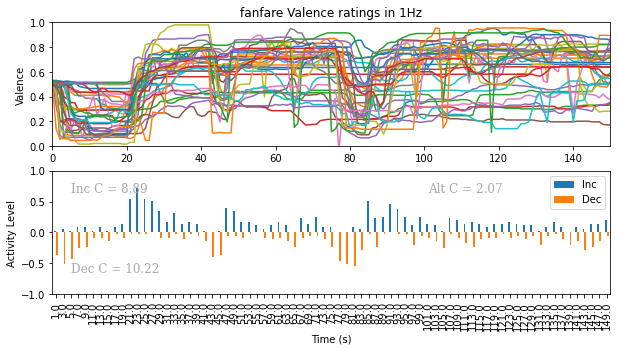

In [36]:
# it is convenient to apply this kind of test to increases, decreases 
# and, using contingency tables, to the alternation between two kinds of activity

fig = plt.figure(figsize=(10,5))
# plot the original rating values for context
ax = fig.add_subplot(211)
D['Data'].plot(ax=ax,legend=False)
plt.ylim(0,1)
plt.xlim(D['Time'][0],D['Time'][-1])
plt.title(D['Piece'] + ' ' + D['Measure'] + ' ratings in ' + str(D['sF']) + 'Hz')
plt.ylabel(D['Measure'])

# evaluate the changes in terms of "activity" for activity analysis.
FrameSize = 2 # evaluate whether a response shows an event over 2 second time frames
HopSize = 2 # evaluate frames every 2 seconds. With HopSize=FrameSize the activity assessed is non-overlapping, i.e. independent.
Thresh = 0.025 # the scalar minimum value of rating change needed in a frame to be counted as an event

# Count the number of responses showing activity in each frame
# first we evaluate the activity levels for increases in ratings (greater than Thresh)
ACTS=act.activityCount(D['Data'],FrameSize,HopSize,Thresh,'Inc')
AC=pd.DataFrame({'Inc':ACTS['Total']})
# then we evaluate the activity levels for decreases in ratings (greater than Thresh)
ACTS=act.activityCount(D['Data'],FrameSize,HopSize,Thresh,'Dec')
AC['Dec'] = -ACTS['Total']

ax = fig.add_subplot(212)
# plot the activity levels for rating changes (inc/dec)
AC.plot.bar(ax=ax)
plt.ylim(-1,1)
plt.ylabel('Activity Level')
plt.xlabel('Time (s)')



# Evaluate the Null Hypothesis that this concentration of rating changes would happen by chance
Nbins = 5 # number of bins used in a chiquare goodness-of-fit test, against stimulus-indenpendent rating changes (binomial/poisson)
# Generate coordination score for increases
actType = 'Inc' #
CInc = act.coordScoreSimple(D['Data'],FrameSize,Thresh,actType,Nbins)
plt.text(2, 0.65, actType + ' C = ' + str(np.round(CInc,2)), fontdict=font)
# Generate coordination score for decreases
actType = 'Dec'
CDec = act.coordScoreSimple(D['Data'],FrameSize,Thresh,actType,Nbins)
plt.text(2, -0.65, actType + ' C = ' + str(np.round(CDec,2)), fontdict=font)
# evaluate coordination score for alternating, assume exclusive but independent actions
CAlt = act.coordScoreAlternating(D['Data'],FrameSize,Thresh,'Inc',Thresh,'Dec')
plt.text(50, 0.65, 'Alt C = ' + str(np.round(CAlt,2)), fontdict=font)
plt.show()

The concentration of changes in each direction are assessed by the simple coordination test, which evaluates how unlikely this distribution of activities levels might arise from the average activity rate. Both increases and decreases are significantly coordinated, with strong scores of 8.9 and 10.2 (a score of 2 corresponds to p = 0.01). Besides moments on activyt concentration in each direction, the directly of change seems to alternate, suggesting that these increases and decreases are not independent rating acts. This alternation is tested against the null hypothesis of independence with the alternating activity test, 

Activity levels are also helpful for exploring activity in responses, to consider what should be counted when evaluating coordinated actions in collections of continuous responses. Here, we evaluate activity while varying a signle parameter, the framesize first, then the activity threshold, to consider which values may best capture the impact of the stimulus and suppress noise when possible.

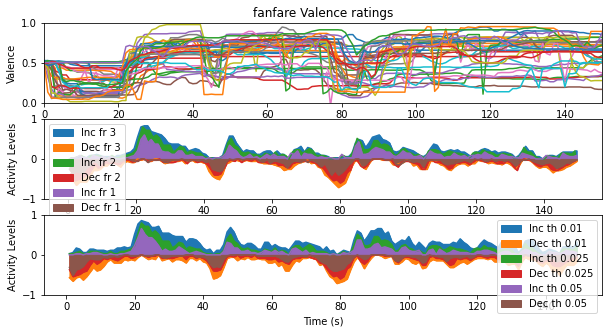

In [38]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(311)
D['Data'].plot(ax=ax,legend=False)
plt.ylim(0,1)
plt.xlim(D['Time'][0],D['Time'][-1])
plt.title(D['Piece'] + ' ' + D['Measure'] + ' ratings')
plt.ylabel(D['Measure'])

ax = fig.add_subplot(312)
for fr in [3,2,1]:
    FrameSize = fr
    HopSize = 1
    Thresh = 0.025
    Nbins = 5
    ACTS=act.activityCount(D['Data'],FrameSize,HopSize,Thresh,'Inc')
    AC=pd.DataFrame({'Inc fr '+ str(fr):ACTS['Total']})
    ACTS=act.activityCount(D['Data'],FrameSize,HopSize,Thresh,'Dec')
    AC['Dec fr '+ str(fr)] = -ACTS['Total']
    AC.plot.area(ax=ax)

plt.ylim(-1,1)
plt.ylabel('Activity Levels')
plt.legend()


ax = fig.add_subplot(313)
for th in [0.01,0.025,0.05]:
    FrameSize = 2
    HopSize = 1
    Thresh = th
    Nbins = 5
    ACTS=act.activityCount(D['Data'],FrameSize,HopSize,Thresh,'Inc')
    AC=pd.DataFrame({'Inc th '+ str(th):ACTS['Total']})
    ACTS=act.activityCount(D['Data'],FrameSize,HopSize,Thresh,'Dec')
    AC['Dec th '+ str(th)] = -ACTS['Total']
    AC.plot.area(ax=ax)

plt.ylim(-1,1)
plt.ylabel('Activity Levels')
plt.legend()
plt.xlabel('Time (s)')

plt.show()

In [ ]:
# alternating activity definition doesn't work yet

# Acts1=aa.activityCount(D['Data'],FrameSize,HopSize,Thresh,'Inc')
# Acts2=aa.activityCount(D['Data'],FrameSize,HopSize,Thresh,'Dec')
# st =  aa.alternatingActivitiesTest(Acts1,Acts2,nBins=3)
# CAlt = aa.coordScoreAlternating(D['Data'],FrameSize,Thresh,'Inc',Thresh,'Dec',Nbins=3)

# fig = plt.figure(figsize=(9,4))
# ax = fig.add_subplot(121)
# sns.heatmap(st['Measured'], ax = ax)
# plt.text(16, 12,'Alt C = ' + str(np.round(CAlt,2)), fontdict=font)
# ax = fig.add_subplot(122)
# sns.heatmap(st['Model'], ax = ax)
# plt.show()

In [82]:
cuts1 = aa.equisplit(MeasuredAll['Measured'],nBins ,nBins*6);
MeasuredAll['Measured']

0      0
1      0
2      0
3      0
4      3
5      2
6      6
7      9
8      8
9     10
10     5
11     7
12     4
13     1
14     6
15     1
16     5
17     0
18     2
19     1
20     3
21     0
22     1
23     0
24     0
25     0
26     1
27     0
28     0
29     0
30     0
31     0
32     0
33     0
34     0
35     0
Name: Measured, dtype: int64

In [84]:
from scipy.stats import binom,chi2
from math import comb
FrameSize = 2
HopSize = 2
Thresh = 0.025
Nbins = 5
Acts1=aa.activityCount(D['Data'],FrameSize,HopSize,Thresh,'Inc')
#AC=pd.DataFrame({'Inc':ACTS['Total']})
Acts2=aa.activityCount(D['Data'],FrameSize,HopSize,Thresh,'Dec')
#AC['Dec'] = -ACTS['Total']

# [Chi,p,DAct,Bins,v1,v2] = alternatingActivitiesTest(AllC1,AllC2,k)
def alternatingActivitiesTest(Acts1,Acts2,nBins = 3): 
    N = Acts1.shape
    Np = N[1]-1
    print(Np)
    L = N[0]
    AC1 =  np.round(Acts1['Total']*Np)
    Acts1 = Acts1.drop(columns=['Total'])
    AC2 =  np.round(Acts2['Total']*Np)
    Acts2 = Acts2.drop(columns=['Total'])

    if L<50:
        print('Too few frames for analysis.')
        #return
    if (Acts1+Acts2).max().max()>1:
        print('These forms of activity are not exclusive, use the biact function instead.')
        #return

    # two criteria for evaluating distribution: Total activity and ratio of one or the other
    ACall =  AC1 + AC2
    p = ACall.sum()/(Np*L) # probability of any activity
    p1 = AC1.sum()/(Np*L) 
    p2 = AC2.sum()/(Np*L)
    p12 = p2/p
    MeasuredAll = pd.DataFrame(0,index = aL,columns = ['Measured'])
    meas = pd.Series(ACall).value_counts()
    MeasuredAll.loc[meas.index,'Measured'] = meas.values


    aL = np.arange(Np+1)
    Model = pd.DataFrame(index = aL)

    for s in range(Np+1):
        subcount = pd.Series(0.0,index = aL)
        for r in range(s+1):
            if s == 0:
                idx = int(0.5*Np)
            else:
                idx = int(Np*(r)/(s+1))
            if s <= 50:
                subcount[idx] = comb(s,r)*((1-p12)**(s-r))*(p12**r)
            else:
                subcount[idx]=math.exp(-s*p12)*((s*p12)**r)/math.factorial(r)
        Model[s] = subcount*MeasuredAll.loc[s].values
    Independent = Model.sum(1)

    Measured = pd.DataFrame(index = aL)
    for s in range(Np+1):
        sub=AC2[ACall==s].value_counts()
        subcount = pd.Series(0.0,index = aL)
        if len(sub)>0:
            subcount = pd.Series(0.0,index = aL)
            for r in sub.index:
                if s == 0:
                    idx = int(0.5*Np)
                else:
                    idx = int(Np*(r)/(s+1))
                subcount[idx] = sub.loc[r]
        Measured[s] = subcount

    cuts1 = aa.equisplit(Independent,nBins ,nBins*6);
    cuts2 = aa.equisplit(MeasuredAll['Measured'],nBins ,nBins*6);

    tabMod = pd.DataFrame()
    tabMea = pd.DataFrame()
    for j in range(len(cuts2)-1):
        a = []
        b = []
        for i in range(len(cuts1)-1):   
            A = Model.loc[cuts1[i]:cuts1[i+1]-1,cuts2[j]:cuts2[j+1]-1]
            a.append(A.sum().sum())
            B = Measured.loc[cuts1[i]:cuts1[i+1]-1,cuts2[j]:cuts2[j+1]-1]
            b.append(B.sum().sum())
        tabMod[j]=np.array(a)
        tabMea[j]=np.array(b)

    st = ((tabMod-tabMea)**2/tabMod).sum().sum()
    p = 1-chi2.cdf(st, sum(tabMod.shape)-2)

    stest = {'Chi2':st,'pvalue':p,'Model':Model,'Measured':Measured,'BinsModel':tabMod,'BinsMeasured':tabMea}
    return stest


35


In [19]:
# demonstrate activity evaluations on a single response, once more options are available (Inc Dec Change UBound Xup etc)

In [91]:
FrameSize = 2
HopSize = 2
Thresh = 0.025
Nbins = 5
Acts1=aa.activityCount(D['Data'],FrameSize,HopSize,Thresh,'Inc')
#AC=pd.DataFrame({'Inc':ACTS['Total']})
Acts2=aa.activityCount(D['Data'],FrameSize,HopSize,Thresh,'Dec')
stest = aa.alternatingActivitiesTest(Acts1,Acts2,nBins = 3) 

35


In [92]:
stest 

{'Chi2': 20.39650127808928,
 'pvalue': 0.0004169713406916298,
 'Model':      0    1    2    3         4         5         6         7         8   \
 0   0.0  0.0  0.0  0.0  0.258157  0.093214  0.151459  0.123049  0.059240   
 1   0.0  0.0  0.0  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
 2   0.0  0.0  0.0  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
 3   0.0  0.0  0.0  0.0  0.000000  0.000000  0.000000  0.000000  0.401093   
 4   0.0  0.0  0.0  0.0  0.000000  0.000000  0.000000  0.728978  0.000000   
 5   0.0  0.0  0.0  0.0  0.000000  0.394451  0.769106  0.000000  0.000000   
 6   0.0  0.0  0.0  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
 7   0.0  0.0  0.0  0.0  0.873944  0.000000  0.000000  0.000000  1.188099   
 8   0.0  0.0  0.0  0.0  0.000000  0.000000  0.000000  1.850870  0.000000   
 9   0.0  0.0  0.0  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
 10  0.0  0.0  0.0  0.0  0.000000  0.000000  1.627294  0.000000  0.000000   
 11  